In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../data/preprocessed/preprocessed_1.csv')

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df):
    X_train = train_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_train = train_df["result_match"]

    X_val = val_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_val = val_df["result_match"]

    X_tst = test_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_tst = test_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    y_pred = model.predict(X_tst)

    f1 = f1_score(y_tst, y_pred)
    return f1

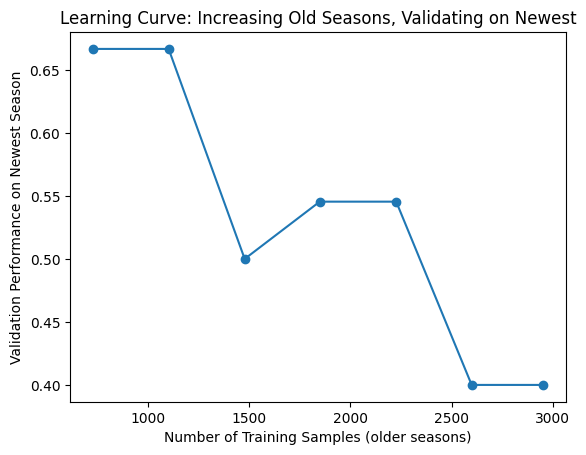

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

sorted_seasons = sorted(df_matches["season"].unique())
newest_season = sorted_seasons[-1]
older_seasons = sorted_seasons[:-1]

max_stage = df_matches.loc[df_matches["season"] == newest_season, "stage"].max()
penultimate_stage = max_stage - 1

train_sizes = []
performances = []

for i in range(1, len(older_seasons) + 1):
    train_seasons = sorted(older_seasons[-i:], reverse=True)

    train_df_older_seasons = df_matches[df_matches["season"].isin(train_seasons)]
    train_df_newest = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]
    train_df = pd.concat([train_df_older_seasons, train_df_newest], ignore_index=True)

    val_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == penultimate_stage)
        ]

    test_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == max_stage)
        ]

    performance_metric = train_and_evaluate(train_df, val_df, test_df)

    train_sizes.append(len(train_df))
    performances.append(performance_metric)

learning_curve_df = pd.DataFrame({
    'train_size': train_sizes,
    'performance': performances
})

plt.plot(learning_curve_df['train_size'], learning_curve_df['performance'], marker='o')
plt.xlabel('Number of Training Samples (older seasons)')
plt.ylabel('Validation Performance on Newest Season')
plt.title('Learning Curve: Increasing Old Seasons, Validating on Newest')
plt.show()

In [5]:
df_matches = df_matches.sort_values(by=["season", "stage", "date"])

train_seasons = sorted(older_seasons[-2:], reverse=True)

X_train_old = df_matches[df_matches["season"].isin(train_seasons)]
X_train_new = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]

df_train = pd.concat([X_train_old, X_train_new], ignore_index=True, )
df_val = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == penultimate_stage)].reset_index(
    drop=True)
df_tst = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == max_stage)].reset_index(drop=True)

X_trn = df_train.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_trn = df_train["result_match"]

X_val = df_val.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_val = df_val["result_match"]

X_tst = df_tst.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_tst = df_tst["result_match"]

In [8]:
X_trn

,home_last_team_goal,home_last_team_shoton,home_last_team_possession,away_last_team_goal,away_last_team_shoton,away_last_team_possession,team_strength_home,strength_difference,team_aggression_home,team_aggression_away,team_acceleration_home,team_acceleration_away,rolling_avg_goals_home,rolling_avg_goals_away,goal_conversion_rate_home,goal_conversion_rate_away
0,1.000000,8.0,49.0,2.0,7.00,56.0,79.490909,8.236364,79.490909,79.490909,79.490909,79.490909,1.533333,1.700000,0.111111,0.250000
1,1.000000,8.0,45.0,1.0,1.00,50.0,76.227273,2.645455,76.227273,76.227273,76.227273,76.227273,1.333333,1.700000,0.111111,0.500000
2,3.000000,5.0,52.0,1.0,11.00,40.0,68.858442,-7.764791,68.858442,68.858442,68.858442,68.858442,1.533333,1.500000,0.500000,0.083333
3,1.000000,4.0,59.0,3.0,6.00,55.0,76.418182,-0.542857,76.418182,76.418182,76.418182,76.418182,1.400000,1.600000,0.200000,0.428571
4,2.000000,3.0,55.0,5.0,5.00,45.0,69.545455,-12.190909,69.545455,69.545455,69.545455,69.545455,1.600000,2.400000,0.500000,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1.000000,2.0,29.0,3.0,4.00,43.0,75.654545,-0.472727,75.654545,75.654545,75.654545,75.654545,1.333333,1.866667,0.333333,0.600000
1097,2.000000,4.0,65.0,4.0,5.25,43.0,77.959740,1.814286,77.959740,77.959740,77.959740,77.959740,1.533333,2.466667,0.400000,0.640000
1098,4.000000,5.0,51.0,4.0,5.00,43.0,76.581818,-2.766234,76.581818,76.581818,76.581818,76.581818,1.933333,3.000000,0.666667,0.666667
1099,1.333333,4.0,66.0,2.0,21.00,67.0,75.990909,10.481818,75.990909,75.990909,75.990909,75.990909,1.866667,3.000000,0.266667,0.090909


In [6]:
(X_trn
 .assign(result_match=y_trn)
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
 )

,home_last_team_goal,home_last_team_shoton,home_last_team_possession,away_last_team_goal,away_last_team_shoton,away_last_team_possession,team_strength_home,strength_difference,team_aggression_home,team_aggression_away,team_acceleration_home,team_acceleration_away,rolling_avg_goals_home,rolling_avg_goals_away,goal_conversion_rate_home,goal_conversion_rate_away,result_match
home_last_team_goal,1.000000,0.080666,-0.054314,-0.014059,0.054038,-0.054947,0.117559,0.090004,0.117559,0.117559,0.117559,0.117559,0.431905,0.018195,0.669331,-0.048846,0.061094
home_last_team_shoton,0.080666,1.000000,-0.269509,-0.019325,-0.022005,0.013343,0.194050,0.176830,0.194050,0.194050,0.194050,0.194050,0.006649,-0.074437,-0.656934,0.010566,0.068222
home_last_team_possession,-0.054314,-0.269509,1.000000,0.047721,-0.001029,0.001823,-0.226950,-0.145317,-0.226950,-0.226950,-0.226950,-0.226950,-0.009609,-0.011088,0.152643,0.037174,-0.071888
away_last_team_goal,-0.014059,-0.019325,0.047721,1.000000,0.102062,-0.088323,0.008645,-0.158826,0.008645,0.008645,0.008645,0.008645,0.047712,0.431268,0.001135,0.669262,-0.127784
away_last_team_shoton,0.054038,-0.022005,-0.001029,0.102062,1.000000,-0.223020,0.046500,-0.077337,0.046500,0.046500,0.046500,0.046500,0.003831,0.053476,0.055175,-0.639451,-0.058624
away_last_team_possession,-0.054947,0.013343,0.001823,-0.088323,-0.223020,1.000000,-0.008506,0.151599,-0.008506,-0.008506,-0.008506,-0.008506,-0.043711,-0.004434,-0.062683,0.104129,0.072777
team_strength_home,0.117559,0.194050,-0.226950,0.008645,0.046500,-0.008506,1.000000,0.700940,1.000000,1.000000,1.000000,1.000000,0.089598,0.040872,-0.052457,-0.023895,0.224385
strength_difference,0.090004,0.176830,-0.145317,-0.158826,-0.077337,0.151599,0.700940,1.000000,0.700940,0.700940,0.700940,0.700940,0.063294,-0.049200,-0.059881,-0.068224,0.274757
team_aggression_home,0.117559,0.194050,-0.226950,0.008645,0.046500,-0.008506,1.000000,0.700940,1.000000,1.000000,1.000000,1.000000,0.089598,0.040872,-0.052457,-0.023895,0.224385
team_aggression_away,0.117559,0.194050,-0.226950,0.008645,0.046500,-0.008506,1.000000,0.700940,1.000000,1.000000,1.000000,1.000000,0.089598,0.040872,-0.052457,-0.023895,0.224385


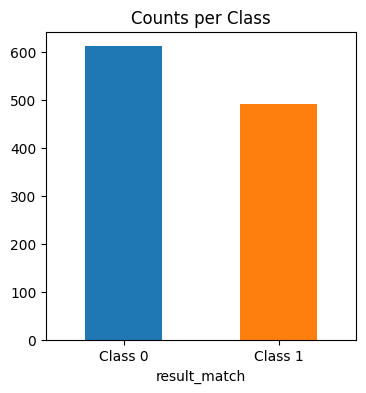

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
y_trn.value_counts().plot(
    kind='bar',
    ax=ax,
    color=['tab:blue', 'tab:orange']
)
ax.set_title('Counts per Class')
ax.set_xticklabels(['Class 0', 'Class 1'], rotation=0)
plt.show()

In [11]:
X_trn['strength_difference'].describe()

count    1101.000000
mean        0.015928
std         5.462478
min       -16.909091
25%        -3.645455
50%        -0.009091
75%         3.518182
max        15.918182
Name: strength_difference, dtype: float64

/tmp/ipykernel_94554/3393717403.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('strength_diff_bin')['result_match']


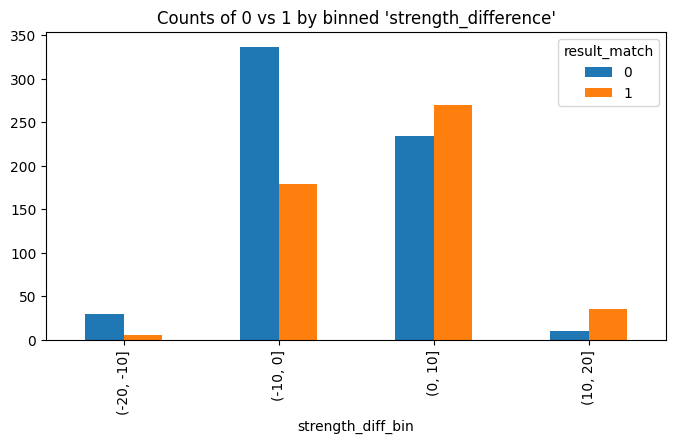

In [13]:
bins = pd.cut(
    X_trn['strength_difference'],
    bins=[-20, -10, 0, 10, 20]
)

X_train = X_trn.assign(result_match=y_trn)
X_train['strength_diff_bin'] = bins

fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .groupby('strength_diff_bin')['result_match']
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
ax.set_title("Counts of 0 vs 1 by binned 'strength_difference'")
plt.show()